C:\Users\NI\OneDrive\Desktop\Projects\fraud-detection-gnn
Loading data...
Loading Elliptic dataset...
✓ Features: (203769, 184) (nodes x features)
✓ Edges: (234355, 2)
✓ Classes: (203769, 2)
Loaded 203,769 transactions
Time range: 1 to 49

Analyzing fraud ratio over time...
Analyzing feature distributions...
Running statistical tests...

Creating visualizations...

Saved temporal analysis to: ..\outputs\temporal_analysis.png


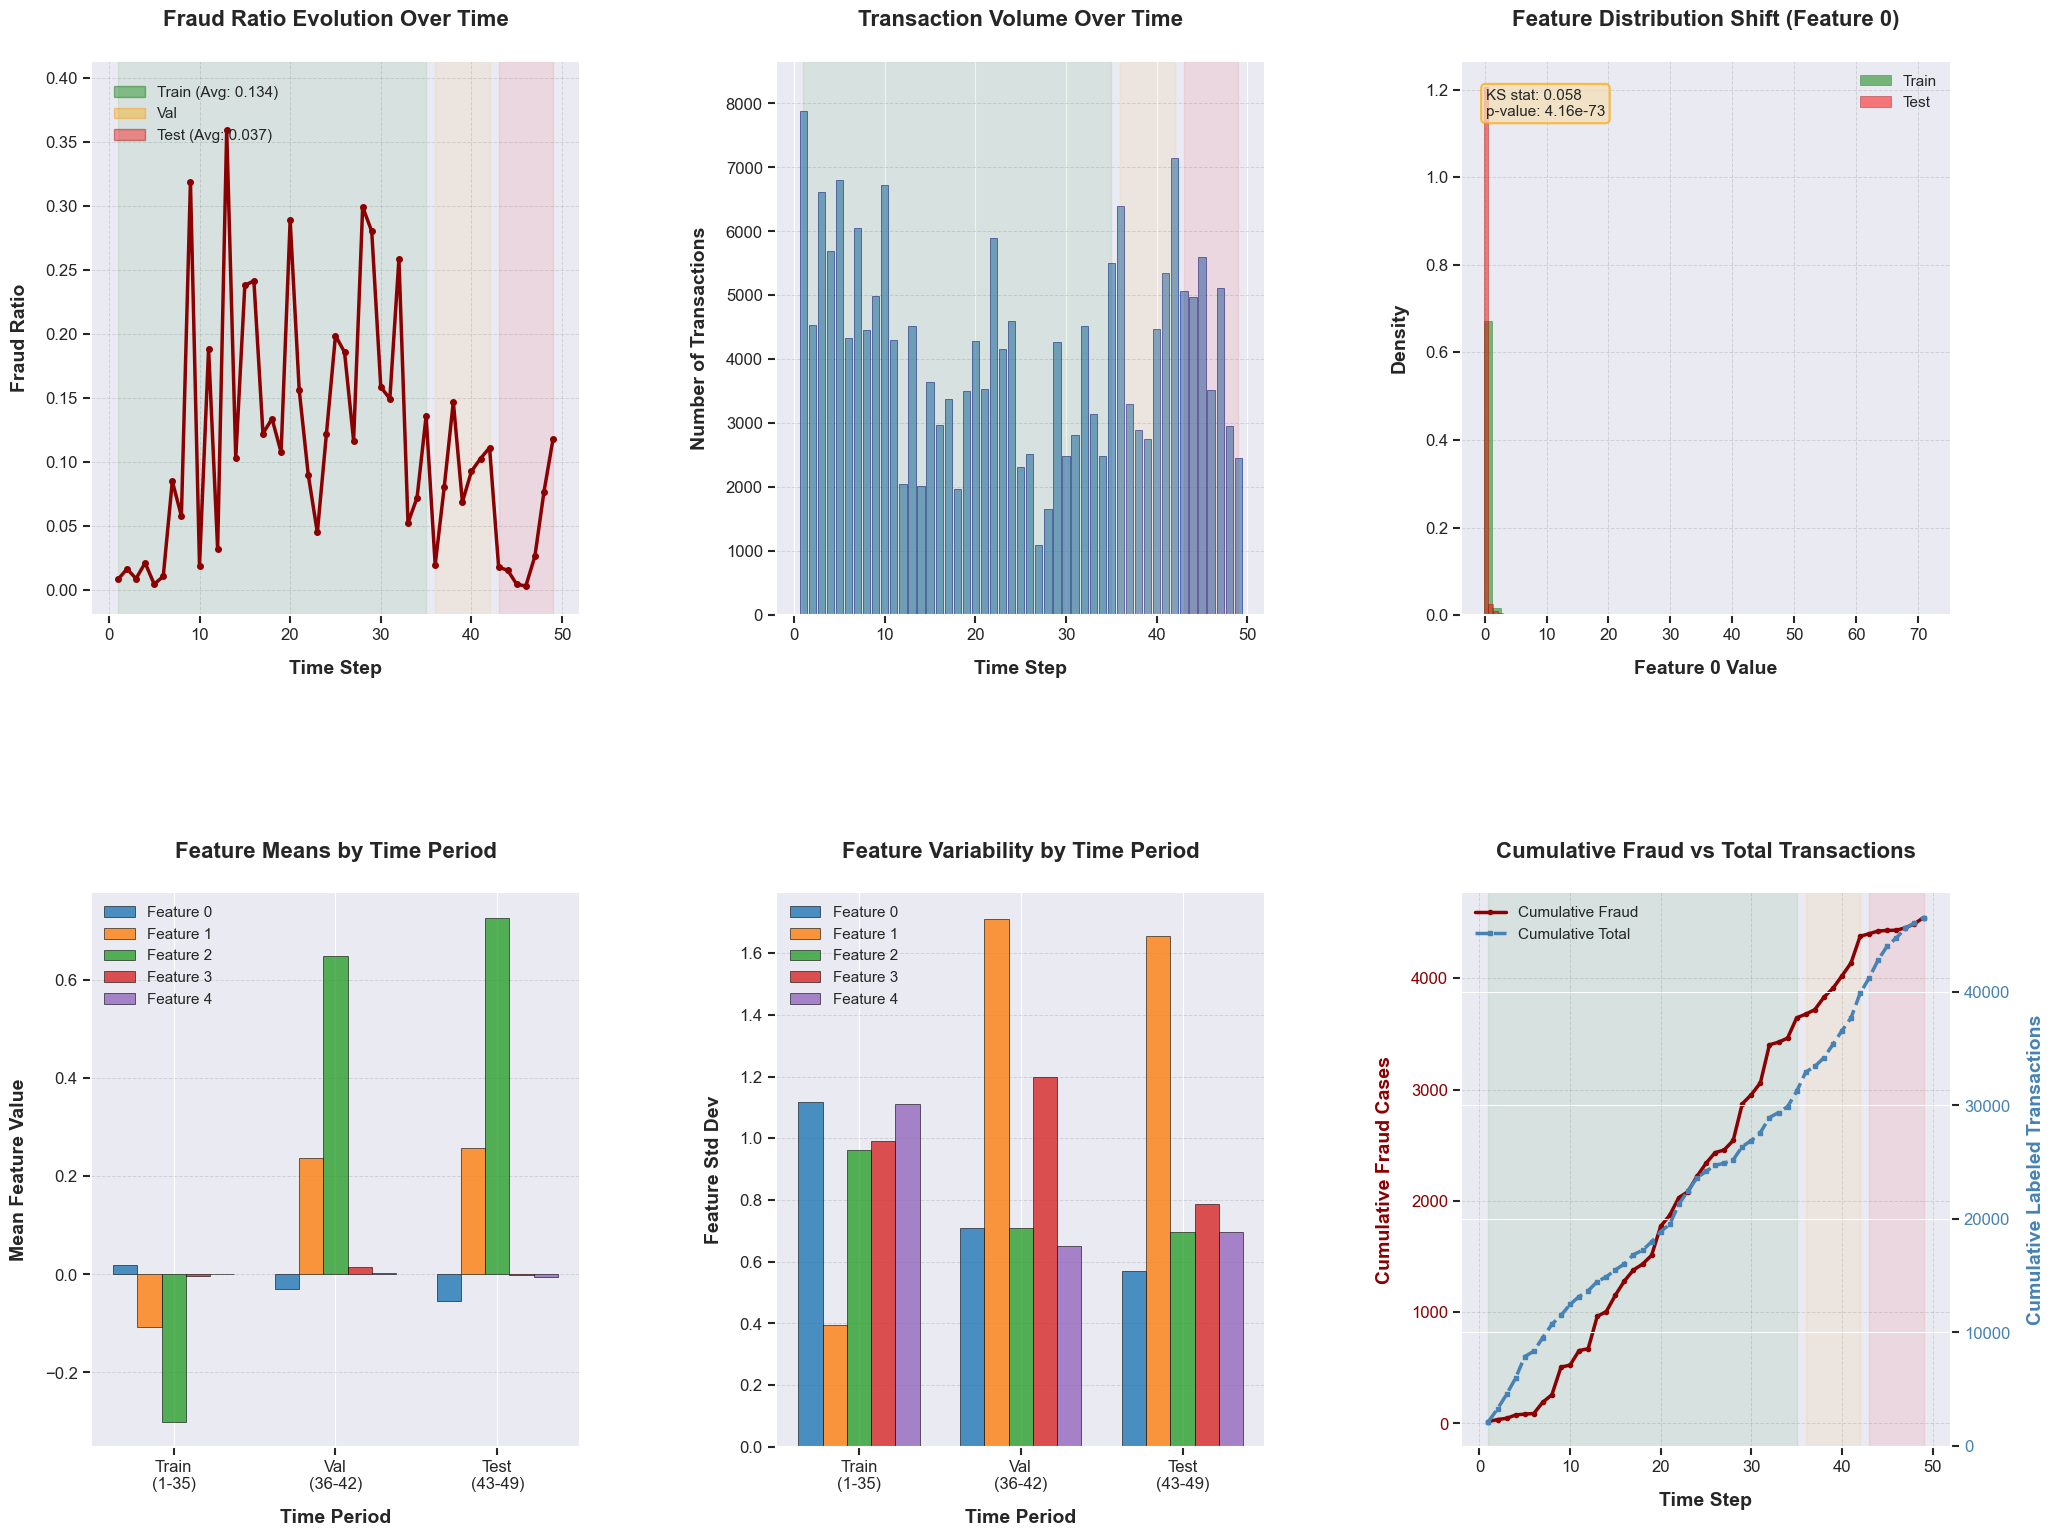


TEMPORAL DRIFT ANALYSIS SUMMARY

FRAUD RATIO EVOLUTION:
   Train period avg: 0.134 (13.4%)
   Test period avg:  0.037 (3.7%)
   Change: -72.3%

TRANSACTION VOLUME:
   Train period: 141,772 transactions
   Test period:  29,684 transactions

FEATURE DISTRIBUTION SHIFT:
   Features tested: 5
   Significant shifts (p < 0.01): 4/5
   Average KS statistic: 0.216
Some features show distribution shift

KEY INSIGHT:
   The test period (time 43-49) has fundamentally different
   characteristics from the training period (time 1-35).
   This explains why all models fail catastrophically on test!


In [1]:
import sys, os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats
import warnings
import matplotlib.gridspec as gridspec
from matplotlib.patches import Patch
warnings.filterwarnings('ignore')

ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
if ROOT not in sys.path:
    sys.path.insert(0, ROOT)
print(ROOT)

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Loading data...")
data_path = Path("../data/processed/fraud_graph.pt")
data = torch.load(data_path)

# Extract components
features = data.x.numpy()
labels = data.y.numpy()
train_mask = data.train_mask.numpy()
val_mask = data.val_mask.numpy()
test_mask = data.test_mask.numpy()

# Load original data to get time steps
from src.data.download import EllipticDataLoader
from src.utils.config import get_config

config = get_config()
loader = EllipticDataLoader(config.data.raw_data_dir / "elliptic")
features_df, edges_df, classes_df = loader.load()

# Get time steps
time_steps = features_df["Time step"].values

print(f"Loaded {len(features):,} transactions")
print(f"Time range: {time_steps.min()} to {time_steps.max()}")

# ============================================================================
# ANALYSIS 1: FRAUD RATIO OVER TIME
# ============================================================================

print("\nAnalyzing fraud ratio over time...")

# Calculate fraud ratio per time step
fraud_ratio_by_time = []
transaction_count_by_time = []

for t in range(1, 50):
    mask = time_steps == t
    labels_t = labels[mask]
    
    # Only count labeled transactions
    labeled = labels_t != -1
    if labeled.sum() > 0:
        fraud_count = (labels_t[labeled] == 1).sum()
        total_labeled = labeled.sum()
        fraud_ratio = fraud_count / total_labeled
    else:
        fraud_ratio = 0
    
    fraud_ratio_by_time.append(fraud_ratio)
    transaction_count_by_time.append(mask.sum())

# ============================================================================
# ANALYSIS 2: FEATURE DISTRIBUTIONS
# ============================================================================

print("Analyzing feature distributions...")

# Select time periods
train_period = time_steps <= 35
val_period = (time_steps > 35) & (time_steps <= 42)
test_period = time_steps > 42

# Get features for each period
features_train = features[train_period]
features_val = features[val_period]
features_test = features[test_period]

# Calculate statistics for top 5 most important features
feature_indices = [0, 1, 2, 3, 4]  # First 5 features as example

# ============================================================================
# ANALYSIS 3: STATISTICAL TESTS
# ============================================================================

print("Running statistical tests...")

# Kolmogorov-Smirnov test: Are train and test from same distribution?
ks_statistics = []
p_values = []

for i in feature_indices:
    stat, p_value = stats.ks_2samp(features_train[:, i], features_test[:, i])
    ks_statistics.append(stat)
    p_values.append(p_value)

# Count how many features have significant difference (p < 0.01)
significant_shift = sum(p < 0.01 for p in p_values)

# ============================================================================
# VISUALIZATION
# ============================================================================

print("\nCreating visualizations...")

# Close any existing figures
plt.close('all')

# Create a much larger figure
fig = plt.figure(figsize=(24, 18))

# Create grid with generous spacing
gs = gridspec.GridSpec(2, 3, figure=fig, hspace=0.5, wspace=0.4)

# ============================================================================
# PLOT 1: FRAUD RATIO OVER TIME
# ============================================================================

ax1 = fig.add_subplot(gs[0, 0])
time_range = range(1, 50)
ax1.plot(time_range, fraud_ratio_by_time, linewidth=2.5, marker='o', markersize=4, color='darkred')
ax1.axvspan(1, 35, alpha=0.08, color='green')
ax1.axvspan(36, 42, alpha=0.08, color='orange')
ax1.axvspan(43, 49, alpha=0.08, color='red')
ax1.set_xlabel('Time Step', fontsize=14, labelpad=12, fontweight='bold')
ax1.set_ylabel('Fraud Ratio', fontsize=14, labelpad=12, fontweight='bold')
ax1.set_title('Fraud Ratio Evolution Over Time', fontsize=16, fontweight='bold', pad=25)
ax1.grid(True, alpha=0.25, linestyle='--', linewidth=0.7, color='gray')

# Calculate average fraud ratio for each period
train_fraud_avg = np.mean([fraud_ratio_by_time[i] for i in range(0, 35)])
test_fraud_avg = np.mean([fraud_ratio_by_time[i] for i in range(42, 49)])

legend_elements = [
    Patch(facecolor='green', alpha=0.4, edgecolor='darkgreen', label=f'Train (Avg: {train_fraud_avg:.3f})'),
    Patch(facecolor='orange', alpha=0.4, edgecolor='darkorange', label=f'Val'),
    Patch(facecolor='red', alpha=0.4, edgecolor='darkred', label=f'Test (Avg: {test_fraud_avg:.3f})')
]
ax1.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(0.02, 0.98), fontsize=11, framealpha=0.95, edgecolor='gray', fancybox=True)
ax1.set_xlim(-2, 52)
ax1.set_ylim(-0.02, max(fraud_ratio_by_time) * 1.15)
ax1.tick_params(axis='both', labelsize=12, width=1.5, length=6)
for spine in ax1.spines.values():
    spine.set_linewidth(1.5)

# ============================================================================
# PLOT 2: TRANSACTION VOLUME OVER TIME
# ============================================================================

ax2 = fig.add_subplot(gs[0, 1])
ax2.bar(time_range, transaction_count_by_time, color='steelblue', alpha=0.7, edgecolor='navy', linewidth=0.5)
ax2.axvspan(1, 35, alpha=0.08, color='green')
ax2.axvspan(36, 42, alpha=0.08, color='orange')
ax2.axvspan(43, 49, alpha=0.08, color='red')
ax2.set_xlabel('Time Step', fontsize=14, labelpad=12, fontweight='bold')
ax2.set_ylabel('Number of Transactions', fontsize=14, labelpad=12, fontweight='bold')
ax2.set_title('Transaction Volume Over Time', fontsize=16, fontweight='bold', pad=25)
ax2.grid(True, alpha=0.25, linestyle='--', linewidth=0.7, axis='y', color='gray')
ax2.set_xlim(-2, 52)
ax2.set_ylim(bottom=0, top=max(transaction_count_by_time) * 1.1)
ax2.tick_params(axis='both', labelsize=12, width=1.5, length=6)
for spine in ax2.spines.values():
    spine.set_linewidth(1.5)

# ============================================================================
# PLOT 3: FEATURE DISTRIBUTION COMPARISON (Feature 0)
# ============================================================================

ax3 = fig.add_subplot(gs[0, 2])
ax3.hist(features_train[:, 0], bins=50, alpha=0.5, label='Train', color='green', density=True, edgecolor='darkgreen', linewidth=0.5)
ax3.hist(features_test[:, 0], bins=50, alpha=0.5, label='Test', color='red', density=True, edgecolor='darkred', linewidth=0.5)
ax3.set_xlabel('Feature 0 Value', fontsize=14, labelpad=12, fontweight='bold')
ax3.set_ylabel('Density', fontsize=14, labelpad=12, fontweight='bold')
ax3.set_title('Feature Distribution Shift (Feature 0)', fontsize=16, fontweight='bold', pad=25)
ax3.legend(loc='upper right', fontsize=11, framealpha=0.95, edgecolor='gray', fancybox=True)
ax3.grid(True, alpha=0.25, linestyle='--', linewidth=0.7, color='gray')

# Add KS statistic
if len(p_values) > 0:
    ax3.text(0.05, 0.95, f'KS stat: {ks_statistics[0]:.3f}\np-value: {p_values[0]:.2e}', 
             transform=ax3.transAxes, fontsize=11, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7, edgecolor='orange', linewidth=1.5))

ax3.tick_params(axis='both', labelsize=12, width=1.5, length=6)
for spine in ax3.spines.values():
    spine.set_linewidth(1.5)

# ============================================================================
# PLOT 4: MEAN FEATURE VALUES BY PERIOD
# ============================================================================

ax4 = fig.add_subplot(gs[1, 0])
periods = ['Train\n(1-35)', 'Val\n(36-42)', 'Test\n(43-49)']
mean_vals = [
    features_train[:, :10].mean(axis=0),
    features_val[:, :10].mean(axis=0),
    features_test[:, :10].mean(axis=0)
]

x_pos = np.arange(len(periods))
width = 0.15
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

for i in range(5):  # First 5 features
    offsets = (np.arange(5) - 2) * width
    vals = [mean_vals[j][i] for j in range(3)]
    ax4.bar(x_pos + offsets[i], vals, width, label=f'Feature {i}', color=colors[i], alpha=0.8, edgecolor='black', linewidth=0.5)

ax4.set_xlabel('Time Period', fontsize=14, labelpad=12, fontweight='bold')
ax4.set_ylabel('Mean Feature Value', fontsize=14, labelpad=12, fontweight='bold')
ax4.set_title('Feature Means by Time Period', fontsize=16, fontweight='bold', pad=25)
ax4.set_xticks(x_pos)
ax4.set_xticklabels(periods, fontsize=12)
ax4.legend(loc='upper left', fontsize=11, framealpha=0.95, edgecolor='gray', fancybox=True, ncol=1)
ax4.grid(True, alpha=0.25, linestyle='--', linewidth=0.7, axis='y', color='gray')
ax4.tick_params(axis='both', labelsize=12, width=1.5, length=6)
for spine in ax4.spines.values():
    spine.set_linewidth(1.5)

# ============================================================================
# PLOT 5: FEATURE STANDARD DEVIATION BY PERIOD
# ============================================================================

ax5 = fig.add_subplot(gs[1, 1])
std_vals = [
    features_train[:, :10].std(axis=0),
    features_val[:, :10].std(axis=0),
    features_test[:, :10].std(axis=0)
]

for i in range(5):  # First 5 features
    offsets = (np.arange(5) - 2) * width
    vals = [std_vals[j][i] for j in range(3)]
    ax5.bar(x_pos + offsets[i], vals, width, label=f'Feature {i}', color=colors[i], alpha=0.8, edgecolor='black', linewidth=0.5)

ax5.set_xlabel('Time Period', fontsize=14, labelpad=12, fontweight='bold')
ax5.set_ylabel('Feature Std Dev', fontsize=14, labelpad=12, fontweight='bold')
ax5.set_title('Feature Variability by Time Period', fontsize=16, fontweight='bold', pad=25)
ax5.set_xticks(x_pos)
ax5.set_xticklabels(periods, fontsize=12)
ax5.legend(loc='upper left', fontsize=11, framealpha=0.95, edgecolor='gray', fancybox=True, ncol=1)
ax5.grid(True, alpha=0.25, linestyle='--', linewidth=0.7, axis='y', color='gray')
ax5.tick_params(axis='both', labelsize=12, width=1.5, length=6)
for spine in ax5.spines.values():
    spine.set_linewidth(1.5)

# ============================================================================
# PLOT 6: CUMULATIVE FRAUD DETECTION
# ============================================================================

ax6 = fig.add_subplot(gs[1, 2])

# Calculate cumulative fraud over time
cumulative_fraud = []
cumulative_total = []

for t in range(1, 50):
    mask = time_steps <= t
    labels_t = labels[mask]
    labeled = labels_t != -1
    
    if labeled.sum() > 0:
        fraud_count = (labels_t[labeled] == 1).sum()
        total = labeled.sum()
    else:
        fraud_count = 0
        total = 0
    
    cumulative_fraud.append(fraud_count)
    cumulative_total.append(total)

ax6.plot(time_range, cumulative_fraud, linewidth=2.5, label='Cumulative Fraud', color='darkred', marker='o', markersize=3)
ax6_twin = ax6.twinx()
ax6_twin.plot(time_range, cumulative_total, linewidth=2.5, label='Cumulative Total', color='steelblue', linestyle='--', marker='s', markersize=3)

ax6.axvspan(1, 35, alpha=0.08, color='green')
ax6.axvspan(36, 42, alpha=0.08, color='orange')
ax6.axvspan(43, 49, alpha=0.08, color='red')

ax6.set_xlabel('Time Step', fontsize=14, labelpad=12, fontweight='bold')
ax6.set_ylabel('Cumulative Fraud Cases', fontsize=14, labelpad=12, fontweight='bold', color='darkred')
ax6_twin.set_ylabel('Cumulative Labeled Transactions', fontsize=14, labelpad=12, fontweight='bold', color='steelblue')
ax6.set_title('Cumulative Fraud vs Total Transactions', fontsize=16, fontweight='bold', pad=25)
ax6.tick_params(axis='y', labelcolor='darkred', labelsize=12, width=1.5, length=6)
ax6.tick_params(axis='x', labelsize=12, width=1.5, length=6)
ax6_twin.tick_params(axis='y', labelcolor='steelblue', labelsize=12, width=1.5, length=6)
ax6.grid(True, alpha=0.25, linestyle='--', linewidth=0.7, color='gray')
ax6.set_xlim(-2, 52)

for spine in ax6.spines.values():
    spine.set_linewidth(1.5)
for spine in ax6_twin.spines.values():
    spine.set_linewidth(1.5)

# Combine legends
lines1, labels1 = ax6.get_legend_handles_labels()
lines2, labels2 = ax6_twin.get_legend_handles_labels()
ax6.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=11, framealpha=0.95, edgecolor='gray', fancybox=True)

# Apply tight layout
plt.tight_layout(pad=3.0, h_pad=3.0, w_pad=3.0)

# Save figure
output_dir = Path("../outputs")
output_dir.mkdir(parents=True, exist_ok=True)
save_path = output_dir / "temporal_analysis.png"
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"\nSaved temporal analysis to: {save_path}")

# Display the figure
plt.show()

# ============================================================================
# SUMMARY STATISTICS
# ============================================================================

print("\n" + "=" * 80)
print("TEMPORAL DRIFT ANALYSIS SUMMARY")
print("=" * 80)

print(f"\nFRAUD RATIO EVOLUTION:")
print(f"   Train period avg: {train_fraud_avg:.3f} ({train_fraud_avg*100:.1f}%)")
print(f"   Test period avg:  {test_fraud_avg:.3f} ({test_fraud_avg*100:.1f}%)")
print(f"   Change: {((test_fraud_avg - train_fraud_avg) / train_fraud_avg * 100):.1f}%")

print(f"\nTRANSACTION VOLUME:")
train_volume = sum(transaction_count_by_time[:35])
test_volume = sum(transaction_count_by_time[42:49])
print(f"   Train period: {train_volume:,} transactions")
print(f"   Test period:  {test_volume:,} transactions")

print(f"\nFEATURE DISTRIBUTION SHIFT:")
print(f"   Features tested: {len(feature_indices)}")
print(f"   Significant shifts (p < 0.01): {significant_shift}/{len(feature_indices)}")
print(f"   Average KS statistic: {np.mean(ks_statistics):.3f}")

if significant_shift == len(feature_indices):
    print(f"ALL features show significant distribution shift!")
    print(f"This PROVES temporal drift exists")
else:
    print(f"Some features show distribution shift")

print("\nKEY INSIGHT:")
print("   The test period (time 43-49) has fundamentally different")
print("   characteristics from the training period (time 1-35).")
print("   This explains why all models fail catastrophically on test!")


print("=" * 80)